In [1]:
pip install tensorflow opencv-python scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "C:/Users/Admin/Desktop/neometrix"
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['good', 'bad'],  
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['good', 'bad'],   
    subset='validation'
)



Found 4681 images belonging to 2 classes.
Found 519 images belonging to 2 classes.


In [3]:
###CNN Model


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_histories = {}

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(train_gen, validation_data=val_gen, epochs=10)
model_histories["Custom CNN"] = history_cnn


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 106s 714ms/step - accuracy: 0.8136 - loss: 0.9470 - val_accuracy: 0.3295 - val_loss: 0.9520
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 118s 800ms/step - accuracy: 0.9042 - loss: 0.2535 - val_accuracy: 0.3719 - val_loss: 1.0451
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 122s 826ms/step - accuracy: 0.9270 - loss: 0.1992 - val_accuracy: 0.4933 - val_loss: 1.1183
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 120s 815ms/step - accuracy: 0.9528 - loss: 0.1187 - val_accuracy: 0.5838 - val_loss: 1.1340
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 108s 734ms/step - accuracy: 0.9681 - loss: 0.0943 - val_accuracy: 0.6647 - val_loss: 1.0141
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 777ms/step - accuracy: 0.9797 - loss: 0.0603 - val_accuracy: 0.7534 - val_loss: 0.9746
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 104s 708ms/step - accuracy: 0.9872 - loss: 0.0362 - val_accuracy: 0.7437 - val_loss: 1.0832
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 105s 715ms/step - accuracy: 0.9863 -

In [5]:
def plot_training_curves(history, model_name="Model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    plot_training_curves(history_cnn, "Custom CNN")



17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step


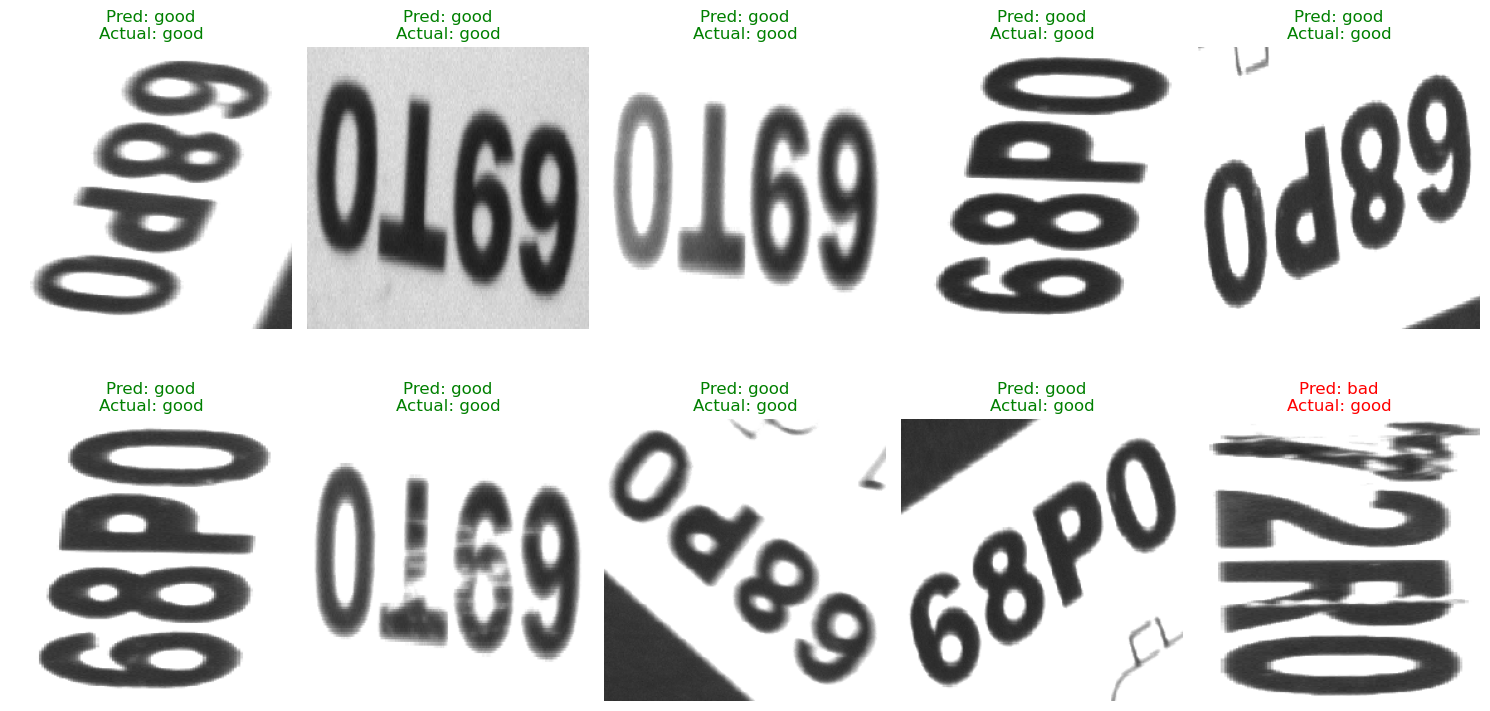

In [6]:
import numpy as np
import matplotlib.pyplot as plt

val_gen.reset()
predictions = (cnn_model.predict(val_gen) > 0.5).astype(int).flatten()
true_labels = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Get batch of images from val_gen
val_images, _ = next(val_gen)

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[i])
    plt.axis('off')
    actual = class_names[true_labels[i]]
    predicted = class_names[predictions[i]]
    color = 'green' if actual == predicted else 'red'
    plt.title(f"Pred: {predicted}\nActual: {actual}", color=color)

plt.tight_layout()
plt.show()


In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def build_transfer_model(base_model, trainable=False):
    base_model.trainable = trainable  # Freeze base layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
from tensorflow.keras.applications import MobileNetV2

mobilenet = build_transfer_model(MobileNetV2(include_top=False, input_shape=(224, 224, 3)))
history_mobilenet = mobilenet.fit(train_gen, validation_data=val_gen, epochs=10)
model_histories["MobileNetV2"] = history_mobilenet


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 102s 662ms/step - accuracy: 0.8258 - loss: 0.4020 - val_accuracy: 0.7958 - val_loss: 0.5186
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 94s 641ms/step - accuracy: 0.9440 - loss: 0.1527 - val_accuracy: 0.7514 - val_loss: 0.6368
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 561ms/step - accuracy: 0.9569 - loss: 0.1198 - val_accuracy: 0.8227 - val_loss: 0.5189
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 90s 614ms/step - accuracy: 0.9669 - loss: 0.0882 - val_accuracy: 0.7457 - val_loss: 0.6147
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 90s 612ms/step - accuracy: 0.9665 - loss: 0.0863 - val_accuracy: 0.8208 - val_loss: 0.5216
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 97s 658ms/step - accuracy: 0.9761 - loss: 0.0657 - val_accuracy: 0.6667 - val_loss: 0.7318
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 90s 610ms/step - accuracy: 0.9736 - loss: 0.0688 - val_accuracy: 0.7996 - val_loss: 0.6311
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 570ms/step - accuracy: 0.9742 - loss: 

In [8]:

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

def build_transfer_model(base_model, trainable=False):
    base_model.trainable = trainable  # Freeze feature extractor
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


model_histories = {}


mobilenet = build_transfer_model(MobileNetV2(include_top=False, input_shape=(224, 224, 3)))
history_mobilenet = mobilenet.fit(train_gen, validation_data=val_gen, epochs=10)

model_histories["MobileNetV2"] = history_mobilenet


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 90s 582ms/step - accuracy: 0.8358 - loss: 0.3839 - val_accuracy: 0.8073 - val_loss: 0.5365
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 569ms/step - accuracy: 0.9407 - loss: 0.1570 - val_accuracy: 0.5222 - val_loss: 0.8607
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 571ms/step - accuracy: 0.9527 - loss: 0.1283 - val_accuracy: 0.8266 - val_loss: 0.5390
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 574ms/step - accuracy: 0.9633 - loss: 0.0956 - val_accuracy: 0.8574 - val_loss: 0.3915
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 569ms/step - accuracy: 0.9596 - loss: 0.0962 - val_accuracy: 0.7283 - val_loss: 0.6964
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 578ms/step - accuracy: 0.9741 - loss: 0.0783 - val_accuracy: 0.8786 - val_loss: 0.4133
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 86s 581ms/step - accuracy: 0.9702 - loss: 0.0753 - val_accuracy: 0.7996 - val_loss: 0.5760
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 578ms/step - accuracy: 0.9790 - loss: 0

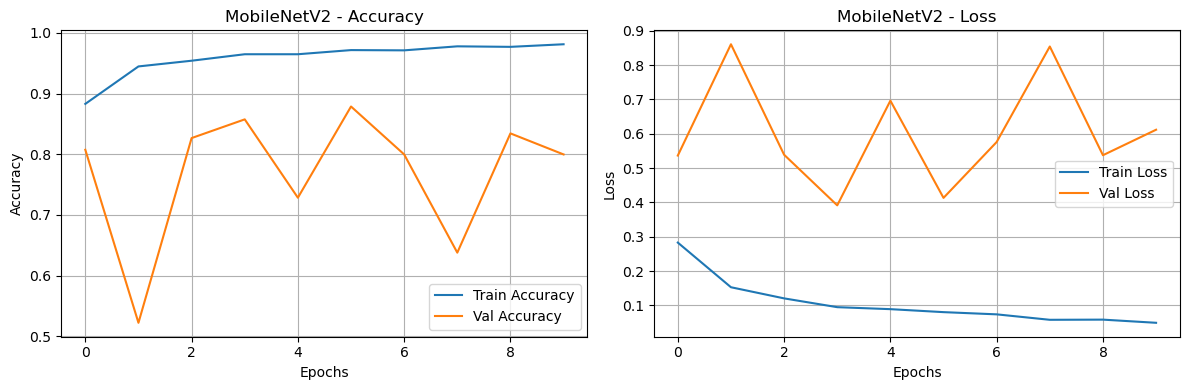

In [9]:
def plot_training_curves(history, model_name="Model"):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_training_curves(history_mobilenet, "MobileNetV2")


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 567ms/step


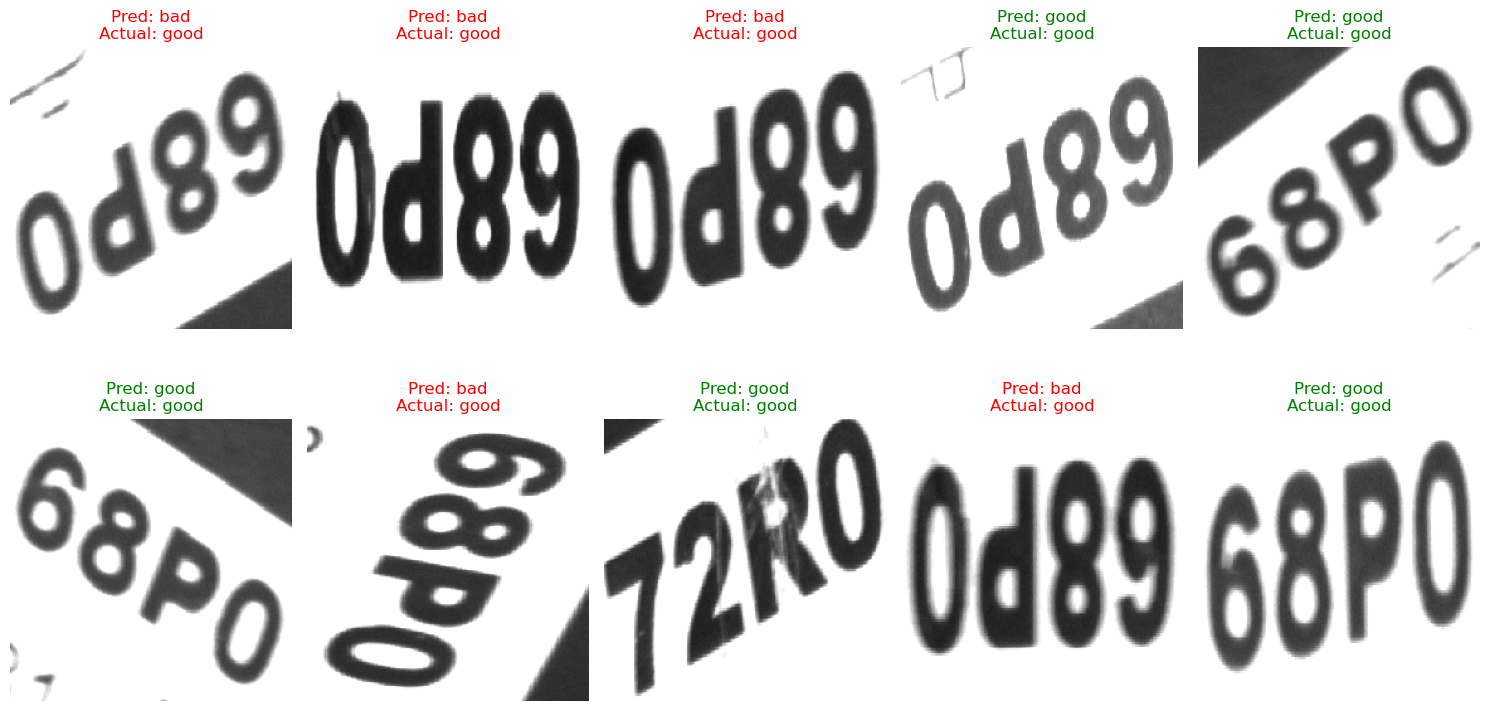

In [10]:
val_gen.reset()
predictions = (mobilenet.predict(val_gen) > 0.5).astype(int).flatten()
true_labels = val_gen.classes
class_names = list(val_gen.class_indices.keys())
val_images, _ = next(val_gen)

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[i])
    plt.axis('off')
    actual = class_names[true_labels[i]]
    predicted = class_names[predictions[i]]
    color = 'green' if actual == predicted else 'red'
    plt.title(f"Pred: {predicted}\nActual: {actual}", color=color)

plt.tight_layout()
plt.show()


In [11]:
from tensorflow.keras.applications import ResNet50

resnet = build_transfer_model(ResNet50(include_top=False, input_shape=(224, 224, 3)))
history_resnet = resnet.fit(train_gen, validation_data=val_gen, epochs=10)

model_histories["ResNet50"] = history_resnet


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8149 - loss: 0.4669 - val_accuracy: 0.5511 - val_loss: 0.7139
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.8308 - loss: 0.3874 - val_accuracy: 0.6262 - val_loss: 0.6530
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.8561 - loss: 0.3513 - val_accuracy: 0.7630 - val_loss: 0.5856
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 409s 3s/step - accuracy: 0.8509 - loss: 0.3462 - val_accuracy: 0.7669 - val_loss: 0.5995
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.8599 - loss: 0.3406 - val_accuracy: 0.7958 - val_loss: 0.5981
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.8630 - loss: 0.3273 - val_accuracy: 0.7360 - val_loss: 0.6399
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.8650 - loss: 0.3203 - val_accuracy: 0.5992 - val_loss: 0.7484
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 853s 6s/step - accuracy: 0.8658 - loss: 0.3067 - val_accu

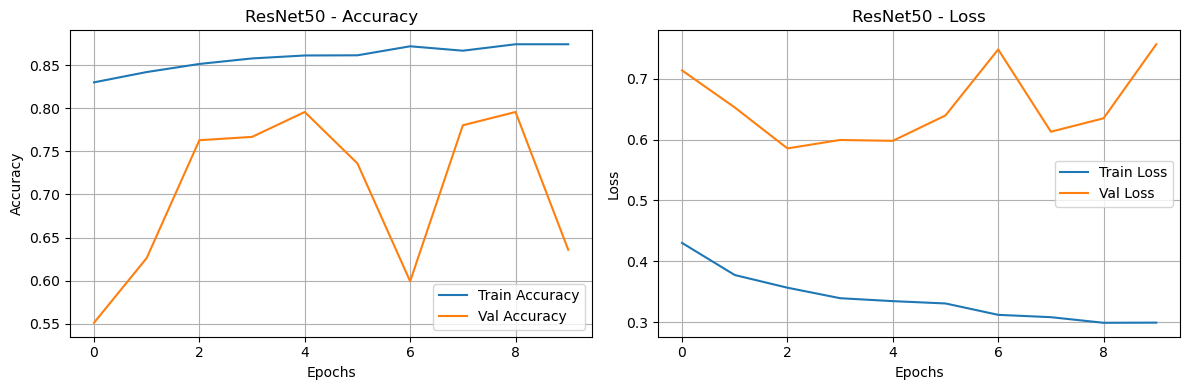

In [12]:


plot_training_curves(history_resnet, "ResNet50")


17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step 


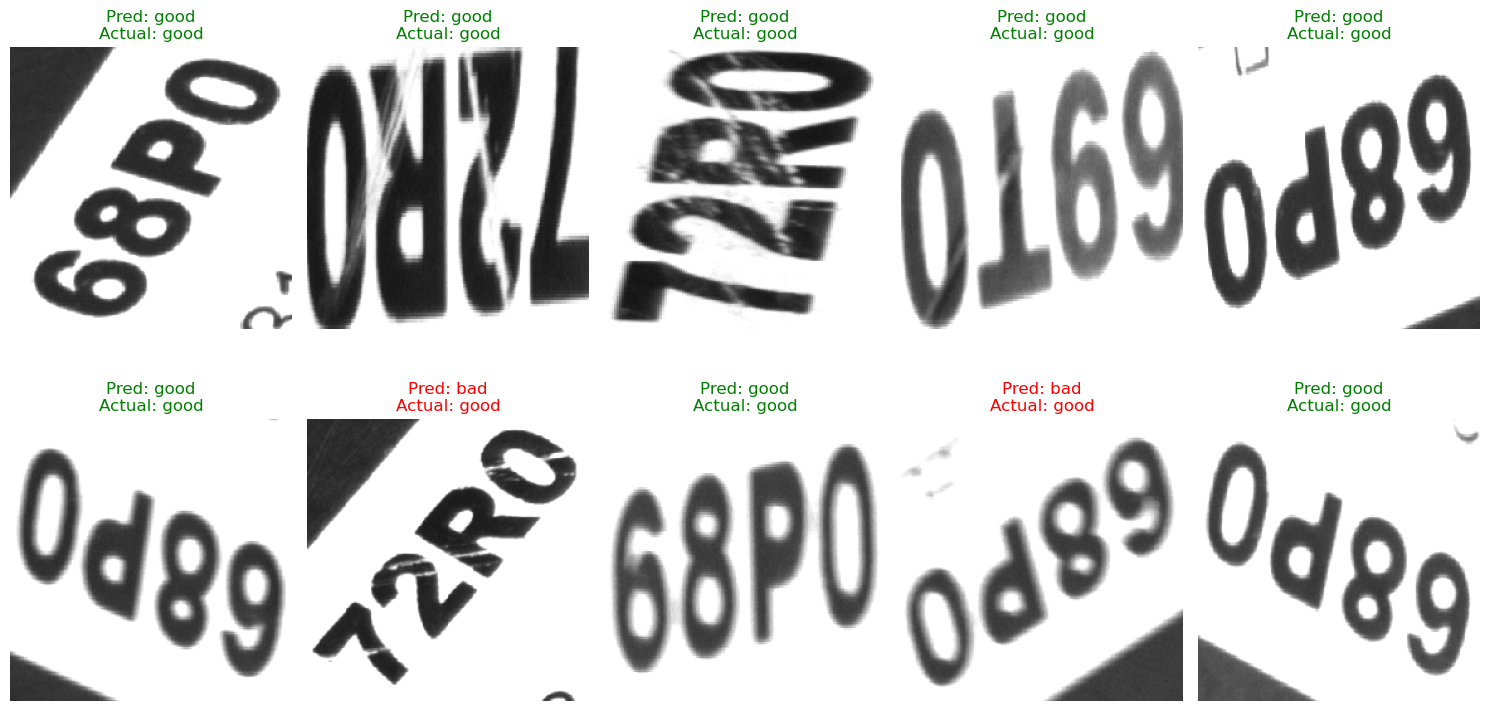

In [13]:
val_gen.reset()
predictions = (resnet.predict(val_gen) > 0.5).astype(int).flatten()
true_labels = val_gen.classes
class_names = list(val_gen.class_indices.keys())
val_images, _ = next(val_gen)

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[i])
    plt.axis('off')
    actual = class_names[true_labels[i]]
    predicted = class_names[predictions[i]]
    color = 'green' if actual == predicted else 'red'
    plt.title(f"Pred: {predicted}\nActual: {actual}", color=color)

plt.tight_layout()
plt.show()


In [38]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, gen, class_names, model_name="Model"):
    gen.reset()
    predictions = (model.predict(gen) > 0.5).astype(int).flatten()
    true_labels = gen.classes
    val_images, _ = next(gen)

    plt.figure(figsize=(15, 8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(val_images[i])
        actual = class_names[true_labels[i]]
        predicted = class_names[predictions[i]]
        color = 'green' if actual == predicted else 'red'
        plt.title(f"Pred: {predicted}\nActual: {actual}", color=color)
        plt.axis('off')
    plt.suptitle(f"{model_name} Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step 


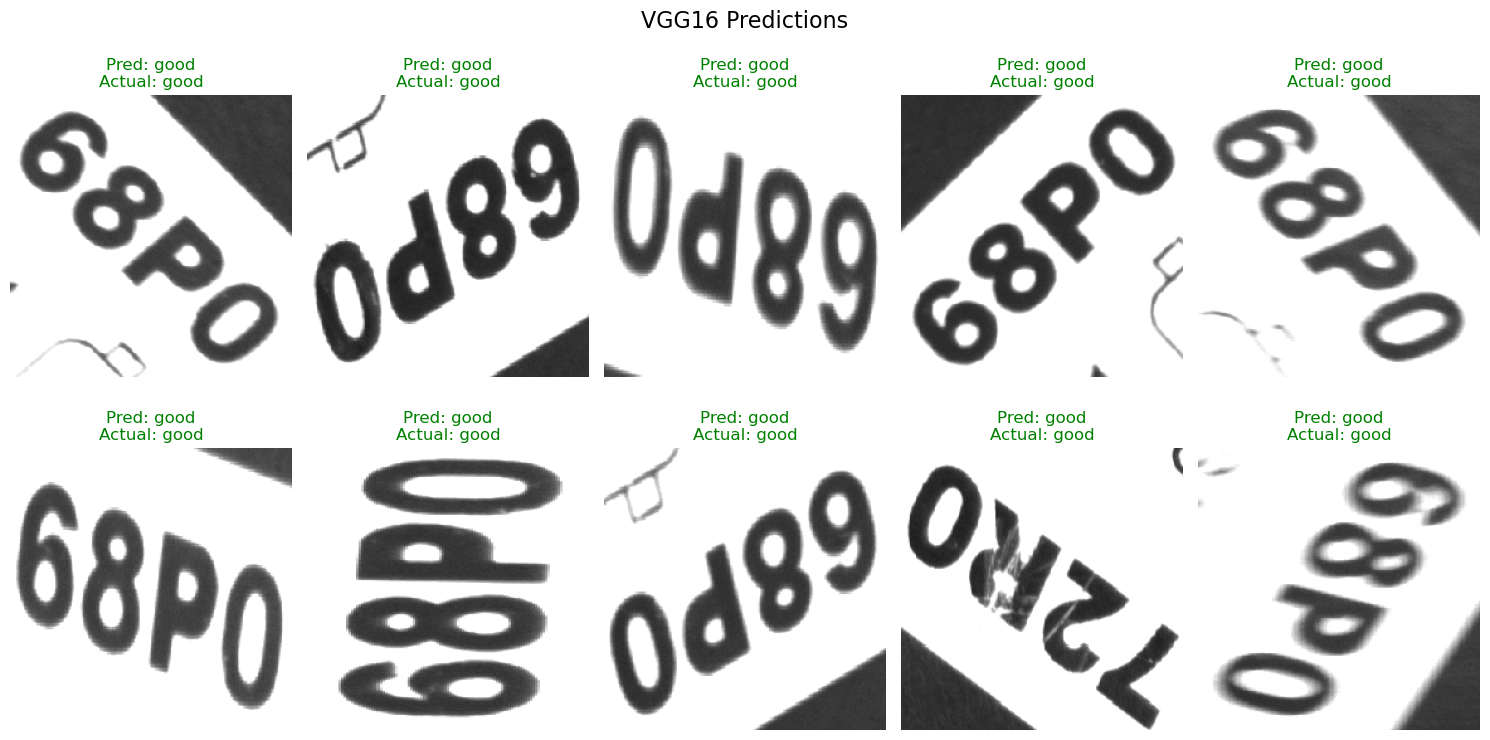

In [40]:
from tensorflow.keras.applications import VGG16

vgg_model = build_transfer_model(VGG16(include_top=False, input_shape=(224, 224, 3)), "VGG16")
show_predictions(vgg_model, val_gen, class_names, "VGG16")


In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def build_transfer_model(base_model, model_name):
    base_model.trainable = False  # Freeze base layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    print(f"\n Training {model_name}...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=5)

    plot_training_curves(history, model_name)
    return model



 Training VGG16...
Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 903s 6s/step - accuracy: 0.7971 - loss: 0.4507 - val_accuracy: 0.3950 - val_loss: 0.7480
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 913s 6s/step - accuracy: 0.8661 - loss: 0.3119 - val_accuracy: 0.6724 - val_loss: 0.6092
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 916s 6s/step - accuracy: 0.8895 - loss: 0.2556 - val_accuracy: 0.8420 - val_loss: 0.4840
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 913s 6s/step - accuracy: 0.9056 - loss: 0.2190 - val_accuracy: 0.8073 - val_loss: 0.5091
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 913s 6s/step - accuracy: 0.9304 - loss: 0.1783 - val_accuracy: 0.7784 - val_loss: 0.5221


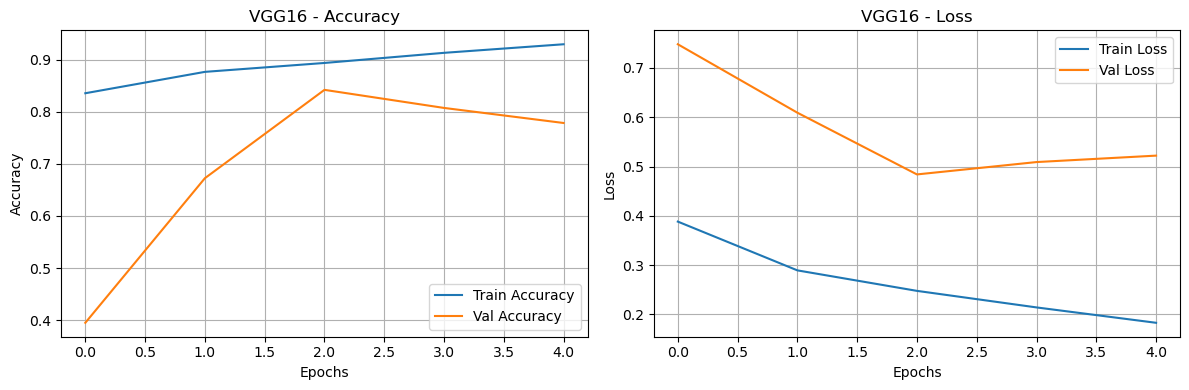

In [46]:
vgg_model = build_transfer_model(VGG16(include_top=False, input_shape=(224, 224, 3)), "VGG16")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 66s 4us/step

 Training EfficientNetB0...
Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 124s 779ms/step - accuracy: 0.8022 - loss: 0.5184 - val_accuracy: 0.8035 - val_loss: 0.5004
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 113s 767ms/step - accuracy: 0.8097 - loss: 0.5001 - val_accuracy: 0.8035 - val_loss: 0.5052
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 113s 766ms/step - accuracy: 0.8136 - loss: 0.4889 - val_accuracy: 0.8035 - val_loss: 0.5096
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 113s 766ms/step - accuracy: 0.7958 - loss: 0.5151 - val_accuracy: 0.8035 - val_loss: 0.5009
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 113s 765ms/step - accuracy: 0.8103 - loss: 0.4937 - val_accuracy: 0.8035 - val_loss: 0.5014


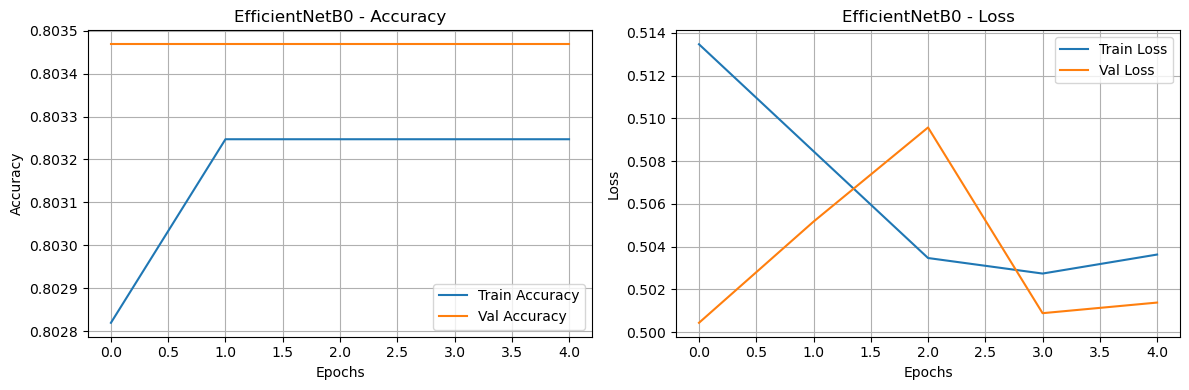

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 797ms/step


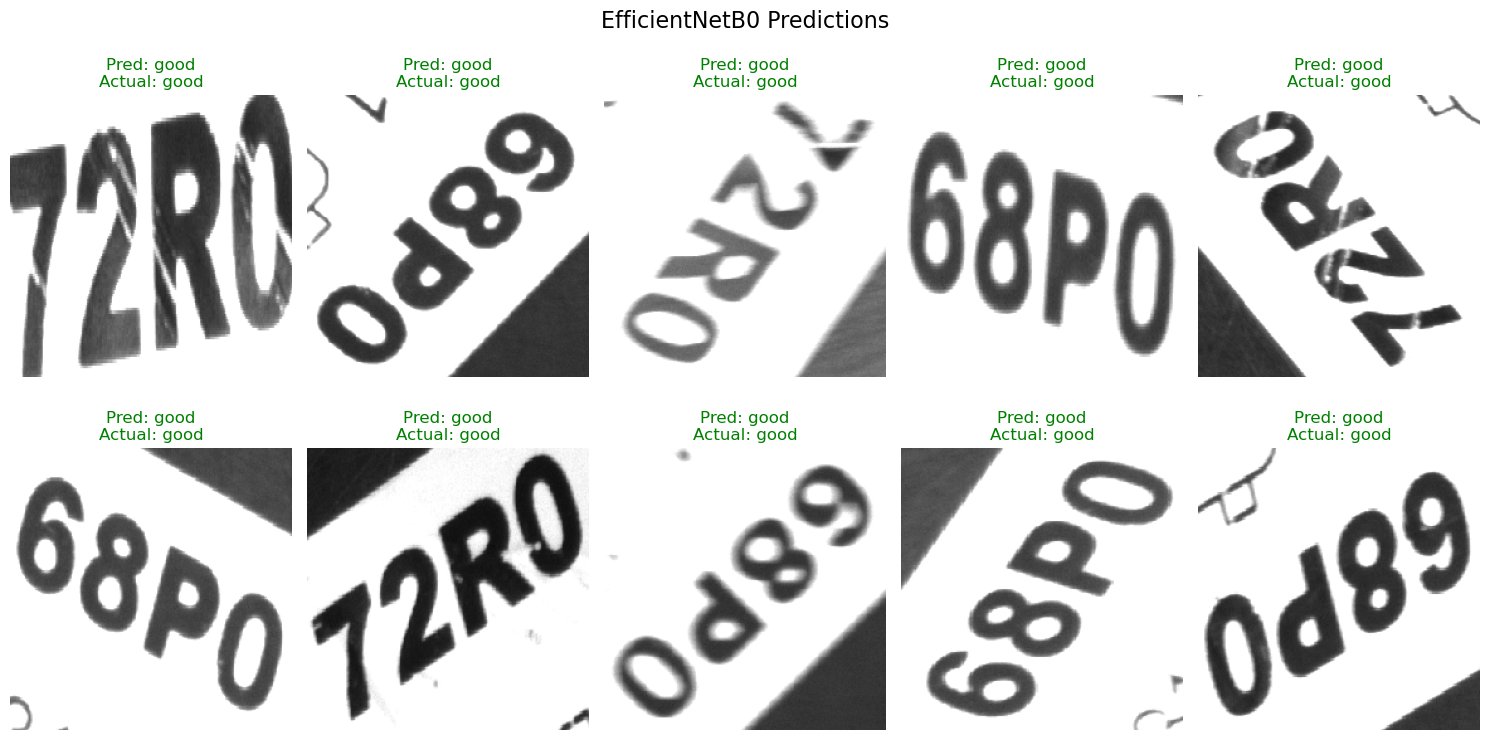

In [48]:
from tensorflow.keras.applications import EfficientNetB0

efficient_model = build_transfer_model(EfficientNetB0(include_top=False, input_shape=(224, 224, 3)), "EfficientNetB0")
show_predictions(efficient_model, val_gen, class_names, "EfficientNetB0")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step 

 Training InceptionV3...
Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8287 - loss: 0.4379 - val_accuracy: 0.8593 - val_loss: 0.4716
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9282 - loss: 0.1900 - val_accuracy: 0.5318 - val_loss: 0.7505
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9430 - loss: 0.1445 - val_accuracy: 0.7225 - val_loss: 0.5729
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9515 - loss: 0.1226 - val_accuracy: 0.8343 - val_loss: 0.4746
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9634 - loss: 0.1116 - val_accuracy: 0.6493 - val_loss: 0.6945


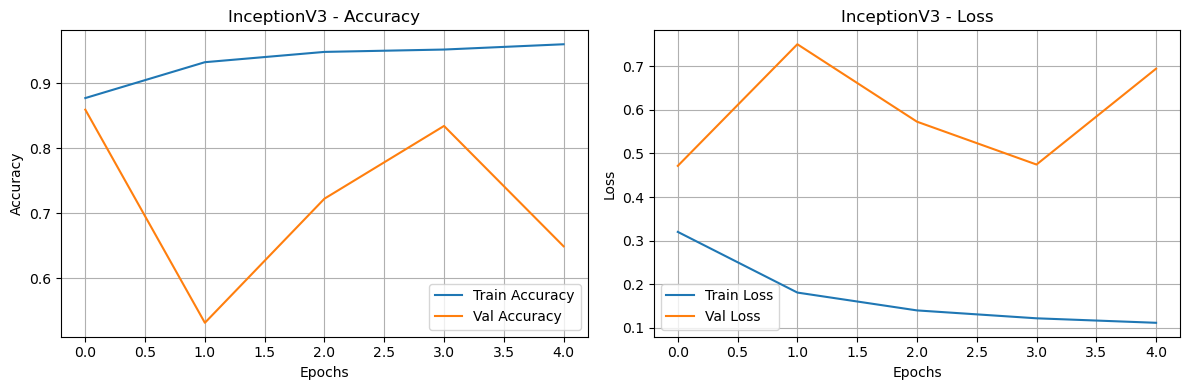

17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


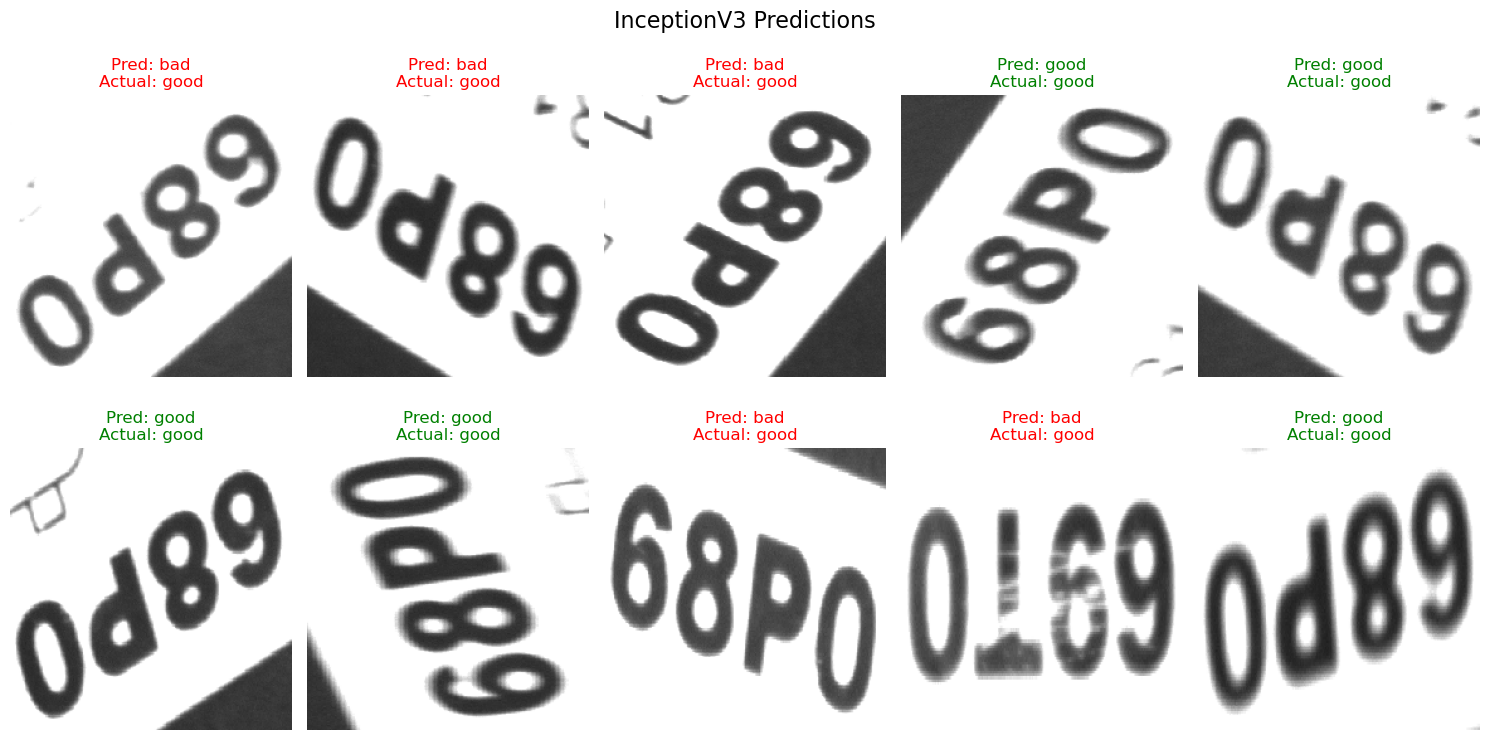

In [50]:
from tensorflow.keras.applications import InceptionV3

inception_model = build_transfer_model(InceptionV3(include_top=False, input_shape=(224, 224, 3)), "InceptionV3")
show_predictions(inception_model, val_gen, class_names, "InceptionV3")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 59s 2us/step 

 Training DenseNet121...
Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8502 - loss: 0.3357 - val_accuracy: 0.7380 - val_loss: 0.4884
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.9419 - loss: 0.1508 - val_accuracy: 0.7688 - val_loss: 0.4836
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9553 - loss: 0.1149 - val_accuracy: 0.8459 - val_loss: 0.3888
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.9635 - loss: 0.0987 - val_accuracy: 0.6840 - val_loss: 0.6038
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9594 - loss: 0.0978 - val_accuracy: 0.6358 - val_loss: 0.6996


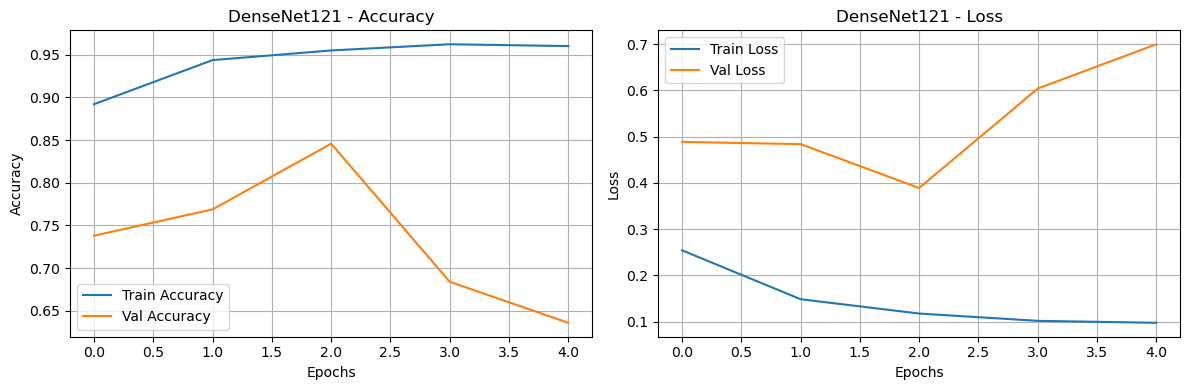

17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step 


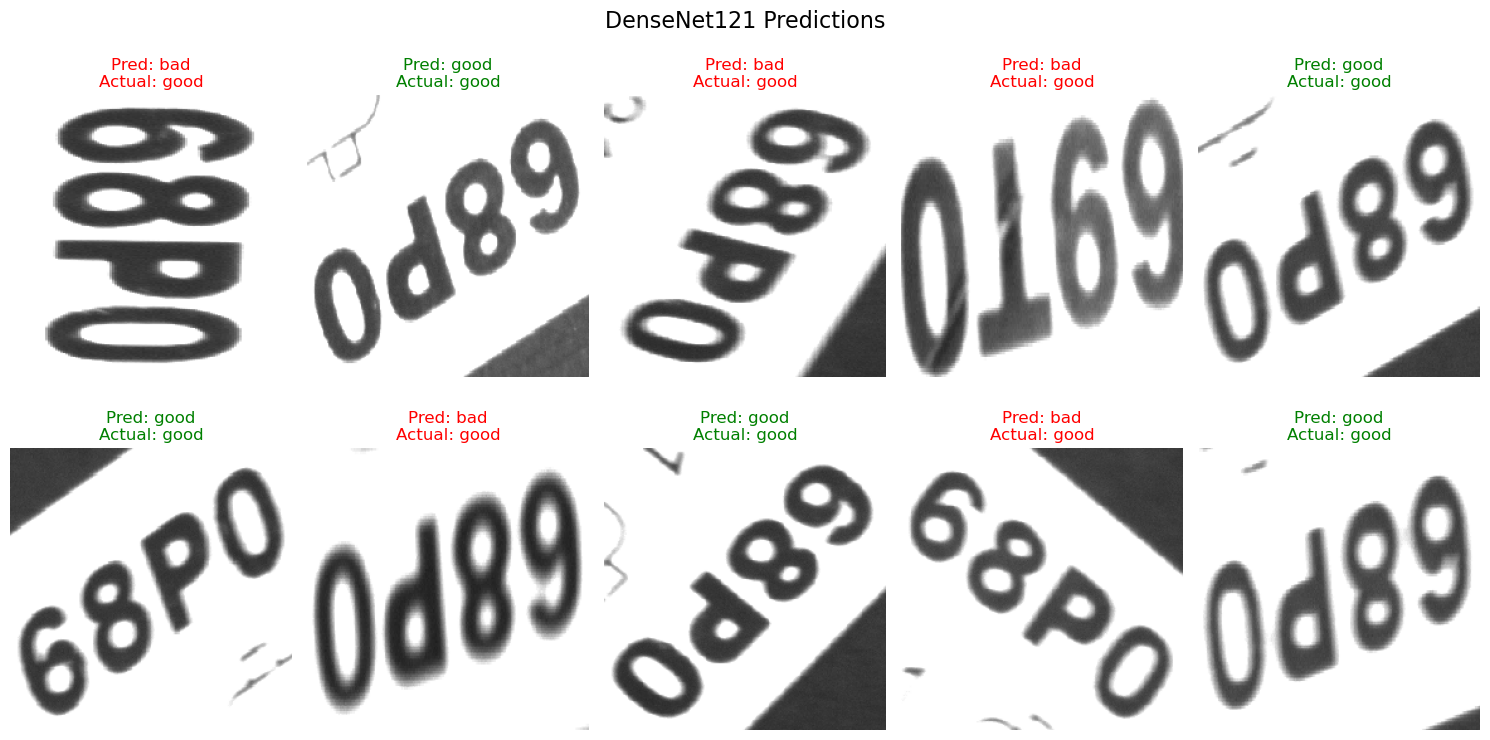

In [52]:
from tensorflow.keras.applications import DenseNet121

densenet_model = build_transfer_model(DenseNet121(include_top=False, input_shape=(224, 224, 3)), "DenseNet121")
show_predictions(densenet_model, val_gen, class_names, "DenseNet121")


Xception

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 Training Xception...
Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step - accuracy: 0.8747 - loss: 0.3272 - val_accuracy: 0.6802 - val_loss: 0.6118
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 462s 3s/step - accuracy: 0.9390 - loss: 0.1638 - val_accuracy: 0.7842 - val_loss: 0.4724
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 531s 4s/step - accuracy: 0.9590 - loss: 0.1162 - val_accuracy: 0.7514 - val_loss: 0.5290
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.9586 - loss: 0.1100 - val_accuracy: 0.8844 - val_loss: 0.2924
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 702s 5s/step - accuracy: 0.9718 - loss: 0.0817 - val_accuracy: 0.8690 - val_loss: 0.3282


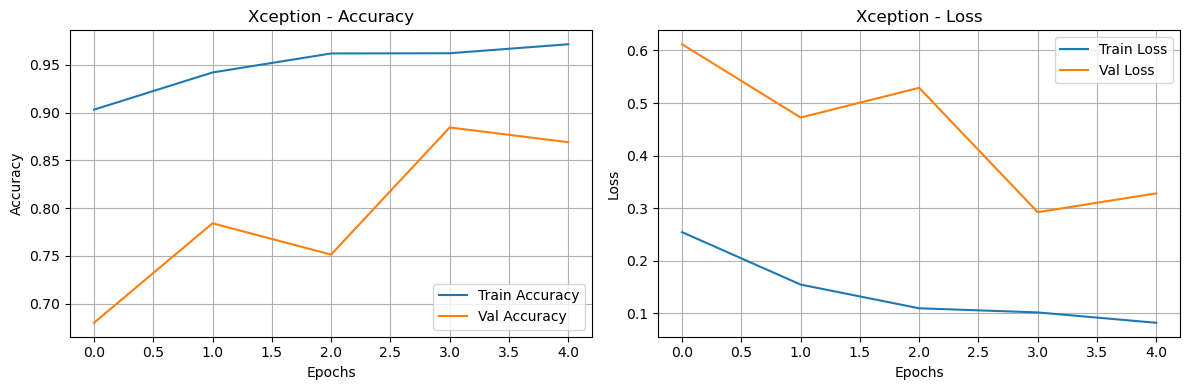

17/17 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step 


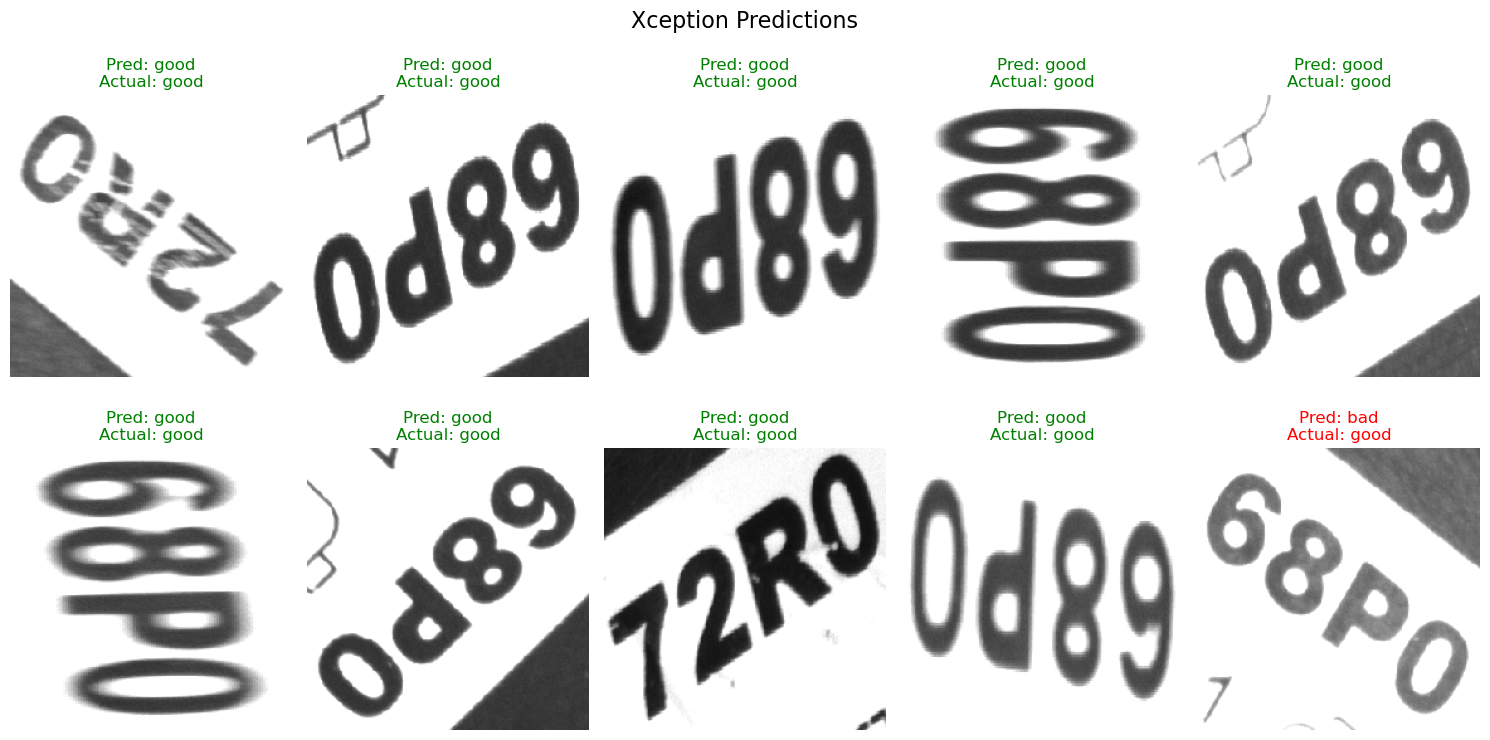

In [54]:
from tensorflow.keras.applications import Xception

xception_model = build_transfer_model(Xception(include_top=False, input_shape=(224, 224, 3)), "Xception")
show_predictions(xception_model, val_gen, class_names, "Xception")
